In [311]:
import torch
import string
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

names =[]
with open("../code/names.txt") as file:
    names = file.read().split("\n")
    
stoi = {c:i for i, c in enumerate(string.ascii_lowercase)}
itos = {c:i for i, c in stoi.items()}

stoi["."] = 26
itos[26] = "."

BLOCK_SIZE = 3
inputs = []
labels = []


for name in names:
    context = [26] * BLOCK_SIZE
    for c in name + ".":
        label = stoi[c]
        inputs.append(context)
        labels.append(label)
#         print("".join(itos[i] for i in context), '-->', itos[label])
        context = context[1:] + [label]

inputs = torch.tensor(inputs)
labels = torch.tensor(labels)

In [312]:
EMBEDDING_DIMENSION = 10
VOCABULARY_SIZE = 27 # 26 alphabets and one special start end char -> "."
HIDDEN_LAYER_NEURONS = 100

CHAR_EMBEDDINGS = torch.randn((VOCABULARY_SIZE, EMBEDDING_DIMENSION)) 
WORD_EMBEDDINGS = CHAR_EMBEDDINGS[inputs]

W1 = torch.randn((EMBEDDING_DIMENSION * BLOCK_SIZE, HIDDEN_LAYER_NEURONS)) * ((5/3) / (EMBEDDING_DIMENSION * BLOCK_SIZE)**0.5)
b1 = torch.randn(HIDDEN_LAYER_NEURONS) * 0.1
W2 = torch.randn((HIDDEN_LAYER_NEURONS, VOCABULARY_SIZE)) * ((5/3) / HIDDEN_LAYER_NEURONS**0.5)
b2 = torch.randn(VOCABULARY_SIZE) * 0.1

# Mul by 0.1 as 1s and 0s mask out smaller changes in grad computation. But we just 
# want to see those as well during this experiment

bngains = torch.randn((1, HIDDEN_LAYER_NEURONS)) * 0.1 + 1.0
bnoffsets = torch.randn((1, HIDDEN_LAYER_NEURONS)) * 0.1

bnmean_running = torch.zeros((1, HIDDEN_LAYER_NEURONS))
bnstd_running = torch.ones((1, HIDDEN_LAYER_NEURONS))

parameters = [CHAR_EMBEDDINGS, W1, W2, b1, b2, bngains, bnoffsets]

for p in parameters:
    p.requires_grad = True
    

In [313]:
EPSILON = 1e-5
# Batching    
batch_idx = torch.randint(0, inputs.shape[0], (BATCH_SIZE,))

# Prepping input to the network
WORD_EMBEDDINGS = CHAR_EMBEDDINGS[inputs[batch_idx]]
WORD_EMBEDDINGS_CAT = WORD_EMBEDDINGS.view(WORD_EMBEDDINGS.shape[0], -1)
batch_labels = labels[batch_idx]

# Layer 1 
pre_batchnorm = WORD_EMBEDDINGS_CAT @ W1 + b1
# Batch Norm
# Mean = Sum / no. of elements; Variance
bnmeani = pre_batchnorm.sum(0, keepdim=True) * (1/BATCH_SIZE)
bndiff = pre_batchnorm - bnmeani
bndiff_squared = bndiff**2
bnvar = bndiff_squared.sum(0, keepdim=True) * (1/(BATCH_SIZE-1)) # Bessel's correction
bnvar_inverse = (bnvar + EPSILON)**-0.5
# Normalize 
bnraw = bndiff * bnvar_inverse
# Preactivation
pre_activation_1 = bngains * bnraw + bnoffsets 
# Activation
h = torch.tanh(pre_activation_1)

# Layer 2
logits = h @ W2 + b2

# Cross entropy
logit_maxes = logits.max(1, keepdim=True).values # Find max of each output tensor
norm_logits = logits - logit_maxes # Subtract corresp. max for math convenience
counts = norm_logits.exp() # Exponentiate
counts_sum = counts.sum(1, keepdim=True) # Count sum of corres. output tensor to normalize 
                                         # and prepare to convert counts to prob
counts_sum_inverse = counts_sum**-1
probs = counts * counts_sum_inverse # Convert to probabilities
logprobs = probs.log() # Take log
loss = -logprobs[range(BATCH_SIZE), batch_labels].mean() # Compute NLL Loss for current batch

# Zero grad
for p in parameters:
    p.grad = None

# Backward Pass

for t in [logprobs, probs, counts, counts_sum, counts_sum_inverse, 
          norm_logits, logit_maxes, logits, h, pre_activation_1, bnraw,
         bnvar_inverse, bnvar, bndiff_squared, bndiff, pre_batchnorm, bnmeani,
         bnstdi, WORD_EMBEDDINGS, WORD_EMBEDDINGS_CAT, CHAR_EMBEDDINGS]:
    t.retain_grad()
loss.backward() 
loss

tensor(3.9552, grad_fn=<NegBackward0>)

In [314]:
# Function to compare manual grad vs pytorch grad
def cmp(measure_name, derivative_computed, actual_variable):
    exact = torch.all(derivative_computed == actual_variable.grad).item()
    approx = torch.allclose(derivative_computed, actual_variable.grad)
    max_diff = (derivative_computed - actual_variable.grad).abs().max().item()
    print(f'{measure_name:20} | exact: {str(exact):4s} | approximate: {str(approx):4s} | maxdiff: {max_diff}')


In [315]:
# Manually compute backpropagation through all variables listed above

# loss = - (a+b+c)/3 = -a/3 + -b/3 + -c/3
# Dl/da = -1/3 ///y for other vars. More generally, -1/n
# Other components do not contribute to loss (only pluck out the prob of the correct next
# character to compute NLL Loss), hence their grad is zero
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(BATCH_SIZE), batch_labels] = -1/BATCH_SIZE
cmp("logprobs", dlogprobs, logprobs)

# d/dx(log x) = 1/x
dprobs = 1/probs * dlogprobs
cmp("probs", dprobs, probs)

# probs = counts * counts_sum_inverse . Tensor broadcast
# c = a * b
# a[3x3] b[3x1]
# a[00] * b[0] a[01] * b[0] a[02] * b[0]
# a[10] * b[1] a[11] * b[1] a[12] * b[1]
# a[20] * b[2] a[21] * b[2] a[22] * b[2]

# dc/db = a[3x3]
# dcounts_sum_inverse = (counts * dprobs) --> for replicated b, but we have non-replicated
# remember from micrograd, if a node is reused, we used += , here we sum 
dcounts_sum_inverse = (counts * dprobs).sum(1, keepdim=True)
cmp("counts_sum_inverse", dcounts_sum_inverse, counts_sum_inverse)

# dc/da = b
dcounts = (counts_sum_inverse * dprobs)
cmp("counts", dcounts, counts)
# counts          | exact: False | approximate: False | maxdiff: 0.020472588017582893
# This is only partial as counts also depends on counts_sum = counts.sum(1, keepdim=True)

# m^n = n * m^(n-1)
dcounts_sum = -counts_sum**-2 * dcounts_sum_inverse
cmp("counts_sum", dcounts_sum, counts_sum)

# a[3x3] ==> b[3x1]
# a[00] + a[01] + a[02] => b[0]
# a[10] + a[11] + a[12] => b[1]
# a[20] + a[21] + a[22] => b[2]
# Addition just backpropogates same value as local gradient is 1.0
dcounts += 1.0 * dcounts_sum
# dcounts += torch.ones_like(counts) * dcounts_sum
cmp("counts", dcounts, counts)
# Now its true as we += and add on the grad backprop effect from before
# counts          | exact: True  | approximate: True  | maxdiff: 0.0

# e^x = e^x
dnorm_logits = counts * dcounts
cmp("norm_logits", dnorm_logits, norm_logits)

# c[3x3] = a[3x3] - b[3x1]
# c[00]  c[01]  c[02] = a[00] - b[0]  a[01] - b[0]  a[02] - b[0]
# c[10]  c[11]  c[12] = a[10] - b[1]  a[11] - b[1]  a[12] - b[1]
# c[20]  c[21]  c[22] = a[20] - b[2]  a[21] - b[2]  a[22] - b[2]
dlogits = dnorm_logits.clone()
cmp("logits", dlogits, logits)

# Is done for numerical stability and does not really affect the loss. 
# Hence gradient should be 0. Check, it will be near-zero. 
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)

# dlogits used once before. So += .logits.max(1) gives both max vals and indices of max vals
# So in one row, except for max's index (to be 1), all else should be 0. One-hot encode
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp("logits", dlogits, logits)

# y = mx + c
# dy/dm = x
# Take 2x2 matrix and easily derivable. Or trick is to make a possible matrix mul with dims
dh = dlogits @ W2.T
cmp("h", dh, h)
db2 = dlogits.sum(0)
cmp("b2", db2, b2)
dW2 = h.T @ dlogits
cmp("W2", dW2, W2)

# dtanh x / dx = 1 - t^2 , where t = tanh(x)
dpre_activation_1 = (1 - h**2) * dh
cmp("pre_activation_1", dpre_activation_1, pre_activation_1)

# Always check the tensor shapes to account for broadcasting
dbngains = (bnraw * dpre_activation_1).sum(0, keepdim=True)
cmp("bngains", dbngains, bngains)

dbnraw = bngains * dpre_activation_1
cmp("bnraw", dbnraw, bnraw)

dbnoffsets = dpre_activation_1.sum(0, keepdim=True)
cmp("bnoffsets", dbnoffsets, bnoffsets)

# Partial
dbndiff = bnvar_inverse * dbnraw
cmp("bndiff", dbndiff, bndiff)

dbnvar_inverse = (bndiff * dbnraw).sum(0, keepdim=True)
cmp("dbnvar_inverse", dbnvar_inverse, bnvar_inverse)

dbnvar = dbnvar_inverse * (-0.5) * (bnvar + EPSILON)**(-1.5)
cmp("bnvar", dbnvar, bnvar)

# Also account for bessel's correction
dbndiff_squared =  ((1/(BATCH_SIZE-1) * dbnvar)).sum(0, keepdim=True)
cmp("bndiff_squared", dbndiff_squared, bndiff_squared)

dbndiff += 2 * bndiff * dbndiff_squared
cmp("bndiff", dbndiff, bndiff)

# Partial
dpre_batchnorm = dbndiff.clone()
cmp("pre_batchnorm", dpre_batchnorm, pre_batchnorm)

dbnmeani = (-dbndiff).sum(0, keepdim=True)
cmp("bnmeani", dbnmeani, bnmeani)

dpre_batchnorm += ((1/BATCH_SIZE) * dbnmeani).sum(0, keepdim=True)
cmp("pre_batchnorm", dpre_batchnorm, pre_batchnorm)

dWORD_EMBEDDINGS_CAT = dpre_batchnorm @ W1.T
cmp("WORD_EMBEDDINGS_CAT", dWORD_EMBEDDINGS_CAT, WORD_EMBEDDINGS_CAT)

dW1 = WORD_EMBEDDINGS_CAT.T @ dpre_batchnorm
cmp("W1", dW1, W1)

db1 = dpre_batchnorm.sum(0, keepdim=True)
cmp("b1", db1, b1)

dWORD_EMBEDDINGS = dWORD_EMBEDDINGS_CAT.view(WORD_EMBEDDINGS.shape)
dCHAR_EMBEDDINGS = torch.zeros_like(CHAR_EMBEDDINGS)
for i in range(inputs[batch_idx].shape[0]):
    for j in range(inputs[batch_idx].shape[1]):
        idx = inputs[batch_idx][i,j]
        dCHAR_EMBEDDINGS[idx] += dWORD_EMBEDDINGS[i,j]
cmp("CHAR_EMBEDDINGS", dCHAR_EMBEDDINGS, CHAR_EMBEDDINGS)

logprobs             | exact: True | approximate: True | maxdiff: 0.0
probs                | exact: True | approximate: True | maxdiff: 0.0
counts_sum_inverse   | exact: True | approximate: True | maxdiff: 0.0
counts               | exact: False | approximate: False | maxdiff: 0.012354373931884766
counts_sum           | exact: True | approximate: True | maxdiff: 0.0
counts               | exact: True | approximate: True | maxdiff: 0.0
norm_logits          | exact: True | approximate: True | maxdiff: 0.0
logits               | exact: False | approximate: True | maxdiff: 6.51925802230835e-09
logits               | exact: True | approximate: True | maxdiff: 0.0
h                    | exact: True | approximate: True | maxdiff: 0.0
b2                   | exact: True | approximate: True | maxdiff: 0.0
W2                   | exact: True | approximate: True | maxdiff: 0.0
pre_activation_1     | exact: True | approximate: True | maxdiff: 0.0
bngains              | exact: True | approximate: Tru

In [316]:
# Simplified NLL Loss

# Before
# Cross entropy
# logit_maxes = logits.max(1, keepdim=True).values # Find max of each output tensor
# norm_logits = logits - logit_maxes # Subtract corresp. max for math convenience
# counts = norm_logits.exp() # Exponentiate
# counts_sum = counts.sum(1, keepdim=True) # Count sum of corres. output tensor to normalize 
#                                          # and prepare to convert counts to prob
# counts_sum_inverse = counts_sum**-1
# probs = counts * counts_sum_inverse # Convert to probabilities
# logprobs = probs.log() # Take log
# loss = -logprobs[range(BATCH_SIZE), batch_labels].mean() # Compute NLL Loss for current batch

# Simplified

loss_simplified = F.cross_entropy(logits, batch_labels)
print(loss_simplified - loss)


tensor(0., grad_fn=<SubBackward0>)


logits               | exact: False | approximate: True | maxdiff: 6.51925802230835e-09


<ipython-input-317-4785259f559f>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  dlogits = F.softmax(logits)


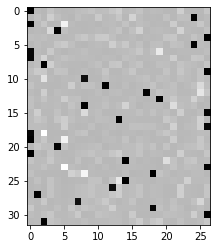

In [317]:
# Now corresponding simplified backward prop for loss
# if correct index -> P[i] - 1 or P[i]

dlogits = F.softmax(logits)
dlogits[range(BATCH_SIZE), batch_labels] -= 1
# Average of losses 
dlogits /= BATCH_SIZE

cmp("logits", dlogits, logits)

# dlogits is a zero-sum game
plt.imshow(dlogits.detach(), cmap="gray")

In [318]:
# BatchNorm simplified

# Before:
# # Batch Norm
# # Mean = Sum / no. of elements; Variance
# bnmeani = pre_batchnorm.sum(0, keepdim=True) * (1/BATCH_SIZE)
# bndiff = pre_batchnorm - bnmeani
# bndiff_squared = bndiff**2
# bnvar = bndiff_squared.sum(0, keepdim=True) * (1/(BATCH_SIZE-1)) # Bessel's correction
# bnvar_inverse = (bnvar + EPSILON)**-0.5
# # Normalize 
# bnraw = bndiff * bnvar_inverse
# # Preactivation
# pre_activation_1 = bngains * bnraw + bnoffsets 

# After:
pre_activation_1_new = bngains * ((pre_batchnorm - pre_batchnorm.mean(0, keepdim=True)) / torch.sqrt(pre_batchnorm.var(0, keepdim=True, unbiased=True) + EPSILON)) + bnoffsets
print((pre_activation_1_new - pre_activation_1).abs().max())


tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [319]:
# Backward pass
dprebatch_norm = bngains * bnvar_inverse / BATCH_SIZE * (BATCH_SIZE * dpre_batchnorm - dpre_batchnorm.sum(0) - BATCH_SIZE/(BATCH_SIZE-1) * bnraw * (dpre_batchnorm * bnraw).sum(0))

cmp('pre_batchnorm', dpre_batchnorm, pre_batchnorm)


pre_batchnorm        | exact: True | approximate: True | maxdiff: 0.0


In [320]:
# Putting them all together ..
EMBEDDING_DIMENSION = 10
VOCABULARY_SIZE = 27 # 26 alphabets and one special start end char -> "."
HIDDEN_LAYER_NEURONS = 100

CHAR_EMBEDDINGS = torch.randn((VOCABULARY_SIZE, EMBEDDING_DIMENSION)) 
WORD_EMBEDDINGS = CHAR_EMBEDDINGS[inputs]

W1 = torch.randn((EMBEDDING_DIMENSION * BLOCK_SIZE, HIDDEN_LAYER_NEURONS)) * ((5/3) / (EMBEDDING_DIMENSION * BLOCK_SIZE)**0.5)
b1 = torch.randn(HIDDEN_LAYER_NEURONS) * 0.1
W2 = torch.randn((HIDDEN_LAYER_NEURONS, VOCABULARY_SIZE)) * ((5/3) / HIDDEN_LAYER_NEURONS**0.5)
b2 = torch.randn(VOCABULARY_SIZE) * 0.1

# Mul by 0.1 as 1s and 0s mask out smaller changes in grad computation. But we just 
# want to see those as well during this experiment

bngains = torch.randn((1, HIDDEN_LAYER_NEURONS)) * 0.1 + 1.0
bnoffsets = torch.randn((1, HIDDEN_LAYER_NEURONS)) * 0.1

bnmean_running = torch.zeros((1, HIDDEN_LAYER_NEURONS))
bnstd_running = torch.ones((1, HIDDEN_LAYER_NEURONS))

parameters = [CHAR_EMBEDDINGS, W1, W2, b1, b2, bngains, bnoffsets]

for p in parameters:
    p.requires_grad = True
    
    
# Expand all functions as much as possible to become BackProp Ninja !
losses = []

STEP_SIZE = 200000
BATCH_SIZE = 32
EPSILON = 1e-5

# Step size vs Epoch
with torch.no_grad():
    for step in range(STEP_SIZE):
        batch_idx = torch.randint(0, inputs.shape[0], (BATCH_SIZE,))

        # Prepping input to the network
        WORD_EMBEDDINGS = CHAR_EMBEDDINGS[inputs[batch_idx]]
        WORD_EMBEDDINGS_CAT = WORD_EMBEDDINGS.view(WORD_EMBEDDINGS.shape[0], -1)
        batch_labels = labels[batch_idx]

        # Layer 1 
        pre_batchnorm = WORD_EMBEDDINGS_CAT @ W1 + b1
        # Batch Norm
        pre_activation_1 = bngains * ((pre_batchnorm - pre_batchnorm.mean(0, keepdim=True)) / torch.sqrt(pre_batchnorm.var(0, keepdim=True, unbiased=True) + EPSILON)) + bnoffsets
        # Activation
        h = torch.tanh(pre_activation_1)

        # Layer 2
        logits = h @ W2 + b2

        # Cross entropy
        loss = F.cross_entropy(logits, batch_labels)

        # Zero grad
        for p in parameters:
            p.grad = None
        
        dlogits = F.softmax(logits)
        dlogits[range(BATCH_SIZE), batch_labels] -= 1
        dlogits /= BATCH_SIZE
        
        dh = dlogits @ W2.T
        db2 = dlogits.sum(0)
        dW2 = h.T @ dlogits
        
        dpre_activation_1 = (1 - h**2) * dh
        dbngains = (bnraw * dpre_activation_1).sum(0, keepdim=True)
        dbnoffsets = dpre_activation_1.sum(0, keepdim=True)
        dprebatch_norm = bngains * bnvar_inverse / BATCH_SIZE * (BATCH_SIZE * dpre_batchnorm - dpre_batchnorm.sum(0) - BATCH_SIZE/(BATCH_SIZE-1) * bnraw * (dpre_batchnorm * bnraw).sum(0))
        dWORD_EMBEDDINGS_CAT = dpre_batchnorm @ W1.T
        dW1 = WORD_EMBEDDINGS_CAT.T @ dpre_batchnorm
        db1 = dpre_batchnorm.sum(0)
        dWORD_EMBEDDINGS = dWORD_EMBEDDINGS_CAT.view(WORD_EMBEDDINGS.shape)
        dCHAR_EMBEDDINGS = torch.zeros_like(CHAR_EMBEDDINGS)
        for i in range(inputs[batch_idx].shape[0]):
            for j in range(inputs[batch_idx].shape[1]):
                idx = inputs[batch_idx][i,j]
                dCHAR_EMBEDDINGS[idx] += dWORD_EMBEDDINGS[i,j]
        
        grads = [dCHAR_EMBEDDINGS, dW1, dW2, db1, db2, dbngains, dbnoffsets]

        
        lr = 0.1 if step < 100000 else 0.01
    
        for p, grad in zip(parameters, grads):
            p.data += -lr * grad
        
        if step % 10000 == 0: 
            print(f'{step:7d}/{STEP_SIZE:7d}: {loss.item():.4f}')
            losses.append(loss.log10().item())

      0/ 200000: 4.0122


<ipython-input-320-26e63d307841>:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  dlogits = F.softmax(logits)


  10000/ 200000: 2.3959
  20000/ 200000: 2.4026
  30000/ 200000: 2.2622
  40000/ 200000: 2.4245
  50000/ 200000: 2.5859
  60000/ 200000: 2.6045
  70000/ 200000: 2.2434
  80000/ 200000: 2.5718
  90000/ 200000: 2.7896
 100000/ 200000: 2.6688
 110000/ 200000: 2.3515
 120000/ 200000: 2.0737
 130000/ 200000: 2.5030
 140000/ 200000: 2.5210
 150000/ 200000: 2.6199
 160000/ 200000: 2.3820
 170000/ 200000: 2.4522
 180000/ 200000: 2.1904
 190000/ 200000: 2.3545
